# Estimating MI by the proposed  adaptive  label  smoothing classifier-based model (AdapLS)

## Setup

The following cell imports the necessary packages:

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
from torch.autograd import Variable
import itertools
from tqdm import tqdm
from data.mix_gaussian import MixedGaussian
from data.gaussian import Gaussian
from model.utils import *
import pdb

Use GPU if GPU is available.

In [38]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

name = './results/AdapLS' # filename
chkpt_name = name+'.pt'                         # checkpoint

Set random seed for reproducibility.

In [23]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

Specify the hyper-parameters:


In [24]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=6, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=0, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_iters", type=int, default=60000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--c_0_1_ratio", type=float, default=1, help="Ratio of samples with label 0 and samples with label 1 ")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--alpha", type=float, default=1e-4, help="smooth parameter")

opt, unknown = parser.parse_known_args()
# adaptive LS parameters
a, b, c = 0.01, 1e-8, 1-1e-8  # a is \alpha_0, b is \tau and c is 1-\tau in the paper

Specify the distribution to generate the data samples:

In [25]:
# Two choices here: 'Gaussian' and 'MixedGaussian
density = 'Gaussian'

## Model

Define the function `generate_data` for generating Gaussian or Mixed Gaussian distributions.

- When generating Gaussian distrition, ${X}$ and ${Y}$ are distributed as 
\begin{align} 
p_{XY} = \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & \rho \\ \rho & 1\\ \end{bmatrix} \right) 
\end{align}
- When generating Mixed Gaussian distributions, ${X}$ and ${Y}$ are distributed as 
 \begin{align} 
 p_{XY} = \frac{1}{2} \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & \rho \\ \rho & 1\\ \end{bmatrix} \right) + \frac{1}{2} \prod_{i=1}^d \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}1 & {-} \rho \\ {-} \rho & 1\\ \end{bmatrix} \right) 
 \end{align}

In [26]:
def generate_data(distribution='Gaussian', rho=0.9):
    # rho is the covariance for generating distributions
    # mu1 and mu2 are means for generating Mixed Gaussian distribution 
    mu1 = 0
    mu2 = 0

    # mg is an object of Class Gaussian or MixedGaussian
    if distribution=='Gaussian':
        mg = Gaussian(sample_size=opt.sample_size,rho=rho)
    else:
        mg = MixedGaussian(sample_size=opt.sample_size, mean1=mu1, mean2=mu2,rho1=rho, rho2=-rho)

    # Calculate the ground truth MI between X and Y for (X, Y) from mg
    mi = mg.ground_truth * opt.d

    # Create X, Y for storing generated samples
    X = np.zeros((opt.sample_size,opt.d))
    Y = np.zeros((opt.sample_size,opt.d))

    # Generate samples of random variable X,Y and XY
    for j in range(opt.d):
        # In each iteration, mg.data will generate samples of two dimensions where one dimension for X and another for Y respectively 
        data = mg.data
        X[:,j] = data[:,0]
        Y[:,j] = data[:,1]        
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    XY = torch.cat((X, Y), dim=1)

    return XY, X, Y, mi

The function `acti_func` below is for calculating the adaptive smoothing weight.
(Clearer motivation and definition of function `acti_func` will be given in the following parts.)

In [27]:
def acti_func(x, a, b, c):
    # a is \alpha_0, b is \tau and c is 1-\tau in the paper
    alpha = torch.zeros_like(x)
    x_cpu = x.cpu()
    alpha[np.where(x_cpu.cpu()<=b)] = - a*x[np.where(x_cpu<=b)]/b + a
    alpha[np.where((x_cpu>b) & (x_cpu<c))] = 0
    alpha[np.where(x_cpu>=c)] = a*x[np.where(x_cpu>=c)]/(1-c) + a*c/(c-1)
    return alpha

Define the neural network.

In [28]:
class Net(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = F.sigmoid(self.fc3(output))
        
        alpha = acti_func(output, a, b, c)

        return output, alpha

The function `_resample` below is for resampling the given data samples for training the neural network.

In [29]:
def _resample(data, batch_size, replace=False):
    # Resample the given data sample.
    index = np.random.choice(
        range(data.shape[0]), size=batch_size, replace=replace)
    batch = data[index]
    return batch

The function `mi_estimate` below returns the empirical estimate of MI given by Probabilistic Classifier Method (PCM):
\begin{align}
I(X, Y) = E \left[ \ln r(X, Y) \right],
\end{align}
where
\begin{align}
r(X, Y) := \frac{p_{C}(0)}{p_{C}(1)} \cdot \frac{p_{{C} | {\tilde{X}}{\tilde{Y}}} (1|x,y)}{p_{{C} | {\tilde{X}}{\tilde{Y}}} (0|x,y)},
\end{align}
and $p_{{C} | {\tilde{X}}{\tilde{Y}}}(1|x,y)$
is implemented by a neural network and may be clipped to a certain range before used for calculating MI estimation.

In [30]:
def mi_estimate(model, XY, gamma, c_0_1_ratio):
    # c_0_1_ratio = p_{C}(0) / p_{C}(1)
    pre, _ = model(XY)
    pre = pre.clamp(min=gamma, max=1-gamma) # clip the output pre controled by gamma; gamma = 0 means no clipping
    MI_est = torch.log(c_0_1_ratio*pre/((1-pre).clamp(min=gamma, max=1-gamma))).mean()

    return MI_est

The function `smooth_ce_loss` returns the binary cross-entropy loss of the predicted value and the smoothed target.


In [31]:
def smooth_ce_loss(pre_label, true_label, smoothing, num_classes):
    new_labels = (1.0 - smoothing) * true_label + smoothing / num_classes
    return torch.nn.BCELoss()(pred_label, new_labels)

The neural network `discriminator` below implements and outputs $p_{{C} | {\tilde{X}}{\tilde{Y}}}(1|x,y)$ before clipping:


In [32]:
discriminator = Net(input_size=opt.d*2, hidden_size=100)
# move NN model GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam opetimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Load previous results.

In [33]:
load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

Previous results loaded.


## Training

We want to obtain $p_{{C} | {\tilde{X}}{\tilde{Y}}}(1|x,y)$ by a neural network $\hat{p}_{\theta}$. 

To train the neural network $\hat{p}_{\theta}$, instead of minimizing the cross-entropy of $\hat{p}_{\theta}$ relative to $p_{{C} | {\tilde{X}}{\tilde{Y}}}$, we propose minimizing the cross-entropy of $\hat{p}_{\theta}$ relative to the distribution
\begin{align}
p^{'}_{{C} | {\tilde{X}}{\tilde{Y}}} := (1-\alpha) \cdot p_{{C} | {\tilde{X}}{\tilde{Y}}} + \alpha \cdot p_{U},
\end{align}
where $p_{U} := \frac{1}{2}$ is the uniform over the labels $\{0, 1\}$ (in fact $p_{U}$ can be any distribution over labels), and $\alpha$ is the smoothing weight.



Here, we use adaptive smoothing weight $\alpha$ which will be given by function `acti_func` called in the forward pass of the neural network $\hat{p}_{\theta}$. The adaptive smoothing weight $\alpha$ depends on the input sample and the neural network, and is defined as follows:
\begin{equation*}
\alpha = \left\{
	 \begin{array}{ll}
	 -\frac{\alpha_{0}}{\tau}\hat{p}_{\theta}(1|\tilde{X},\tilde{Y})+\alpha_{0}, &
	 \hat{p}_{\theta}(1|\tilde{X},\tilde{Y})\in[0,\tau], \\
	 0, & \hat{p}_{\theta}(1|\tilde{X},\tilde{Y})\in(\tau,1-\tau), \\
	 \frac{\alpha_{0}}{\tau}\hat{p}_{\theta}(1|\tilde{X},\tilde{Y})+\frac{\tau-1}{\tau}\alpha_{0}, & \hat{p}_{\theta}(1|\tilde{X},\tilde{Y})\in[1-\tau,1],
	 \end{array}
\right.
\end{equation*}
where $\alpha_{0} \in [0, 1]$ is the maximum regularization weight and $\tau \in (0, \frac{1}{2})$ is the threshold to judge whether the classifier is starting to get overconfident.

We train the neural network with adative smoothing weight and $p^{'}_{{C} | {\tilde{X}}{\tilde{Y}}}$, while when we evaluate the MI estimate by the trained neural network, we use the function `mi_estimate` which is based on MI estimation by Probabilistic Classifier Method (PCM) method and uses $p_{{C} | {\tilde{X}}{\tilde{Y}}}$ instead of $p^{'}_{{C} | {\tilde{X}}{\tilde{Y}}}$.

The following cell train the neural network using the data samples.

In [34]:
XY, X, Y, Ground_truth = generate_data(distribution=density, rho=opt.rho)
continue_train = False  # set to True to continue to train
if continue_train:
    for i in range(opt.n_iters):
        data_joint = _resample(XY, batch_size=opt.batch_size)
        X_ref = resample(X, batch_size=opt.batch_size)
        Y_ref = resample(Y, batch_size=opt.batch_size)
        data_margin = torch.cat((X_ref, Y_ref), dim=1)
        valid = Variable(torch.Tensor(opt.batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.Tensor(opt.batch_size, 1).fill_(0.0), requires_grad=False)
        train_data = torch.cat((data_joint, data_margin), dim=0)
        labels = torch.cat((valid, fake), dim=0)
        pred_label, alpha = discriminator(train_data) # alpha is the adaptive label smoothing weight
        # print(alpha)
        c_0_1_ratio = data_margin.shape[0]/data_joint.shape[0] # c_0_1_ratio = p_{C}(0) / p_{C}(1) 
        
        optimizer_D.zero_grad()
        loss = smooth_ce_loss(pred_label, labels, alpha.detach(), 2) # cross-entropy of $\hat{p}_{\theta}$ relative to the distribution p^{'}_{C}
        loss.backward()
        optimizer_D.step()
        
        with torch.no_grad():
            mi_est = mi_estimate(discriminator, XY, opt.gamma, c_0_1_ratio)
            if torch.isinf(mi_est):
                mi_est = torch.from_numpy(np.array(mi_list[-1]))
            mi_list.append(mi_est.item())
        if i%500==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))

## MI estimates

Use moving average to smooth the estimated MI in each training iteration.

In [35]:
ma_rate = 0.01
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]


Plot the MI estimation curve against the training iteration, together the ground truth.

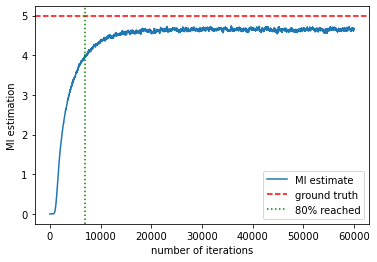

In [36]:
plt.plot(mi_copy, label='MI estimate')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
for t in range(len(mi_copy)):
    if (mi_copy[t]>.8*Ground_truth):
        plt.axvline(t,label='80% reached',linestyle=':',color='green')
        break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()


Save the model.


In [39]:
overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator.state_dict()
    torch.save({
        'mi_list': mi_list,
        'mi_copy': mi_copy,
        'model_state': model_state
    }, chkpt_name)
    print('Current results saved.')

Current results saved.
